In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Анализ тональности твитов
## Расчетно-графическая работа
### Выполнил: Заморщиков В.К., гр. АММ2-19

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('stopwords')
import gensim

from collections import Counter
import pickle
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Датасет
* target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", names=["target", "ids", "date", "flag", "user", "text"])
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
#Для увеличения скорости вычисления, но, на самом деле, этого делать не нужно
import random
random_idx = random.sample(range(0, len(df)), 800000)
df.drop(random_idx, axis=0, inplace=True)

In [5]:
map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def sentiment(label):
    return map[int(label)]

In [6]:
df.target = df.target.apply(lambda x: sentiment(x))

In [28]:
df

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
6,NEGATIVE,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug
7,NEGATIVE,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time see yes rains bit bit lol fine t...
9,NEGATIVE,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera
...,...,...,...,...,...,...
1599983,POSITIVE,2193578758,Tue Jun 16 08:38:57 PDT 2009,NO_QUERY,xoAurixo,theri tomorrow drinking coffee talking importa...
1599984,POSITIVE,2193578847,Tue Jun 16 08:38:57 PDT 2009,NO_QUERY,RobFoxKerr,heard first girl hope looks wendy brains kiddi...
1599987,POSITIVE,2193579092,Tue Jun 16 08:38:58 PDT 2009,NO_QUERY,cathriiin,neveer think get well
1599990,POSITIVE,2193579249,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,razzberry5594,wooooo xbox back


Text(0.5, 1.0, 'Баланс классов')

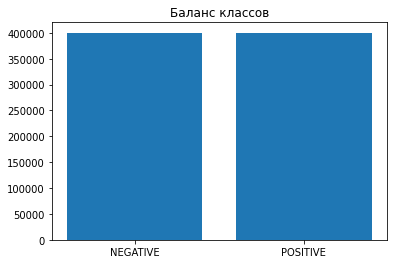

In [7]:
target_cnt = Counter(df.target)
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Баланс классов")

In [14]:
for i in range(10):
  print(df.text.iloc[random.randint(0, 800000)]) 
  print('\n')

Eating Greek in Montreal. Yum. 


@TinainMelbourne sounds like fun! Keep me posted 


@kellz326 I got the emails imma finish up the designs asap I moved do my pc was down for a bit but im back now 


@allysonnewell I don't know if they have one yet - I'd suggest following @cgmoyer in the meantime 


@JoelMadden it must be nice to forget when you're on international television 


@NinjaNorman If you still have the memory card, don't use it &amp; buy another.  As the images are probably recoverable.   If lost though... 


 have the cold its horrible . cant stop sneezing x


Just had an email off the lottery Lottery - I thought I had won... alas, no! it was an email to say my online ticket had ended! 


@DakotaCassidy More likely Judy, but yeah, I reckon you're right 


Ugh awake an hour before I wanted to 




### Предобработка

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
print('{} ----> {}'.format("dog's", stemmer.stem("dog's")))
print('{} ----> {}'.format("nation", stemmer.stem("nation")))
print('{} ----> {}'.format("unfortunable", stemmer.stem("unfortunable")))
print('{} ----> {}'.format("understandable", stemmer.stem("understandable")))

dog's ----> dog
nation ----> nation
unfortunable ----> unfortun
understandable ----> understand


In [23]:
#Для удаления ссылок, эмодзи
text_cleaning = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def cleaning(text, stem=False):
    text = re.sub(text_cleaning, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [24]:
df.text = df.text.apply(lambda x: cleaning(x))
df.text

0               awww bummer shoulda got david carr third day
1          upset update facebook texting might cry result...
6                                                   need hug
7          hey long time see yes rains bit bit lol fine t...
9                                                  que muera
                                 ...                        
1599983    theri tomorrow drinking coffee talking importa...
1599984    heard first girl hope looks wendy brains kiddi...
1599987                                neveer think get well
1599990                                     wooooo xbox back
1599994    yeah work better waiting end wonder time keep ...
Name: text, Length: 800000, dtype: object

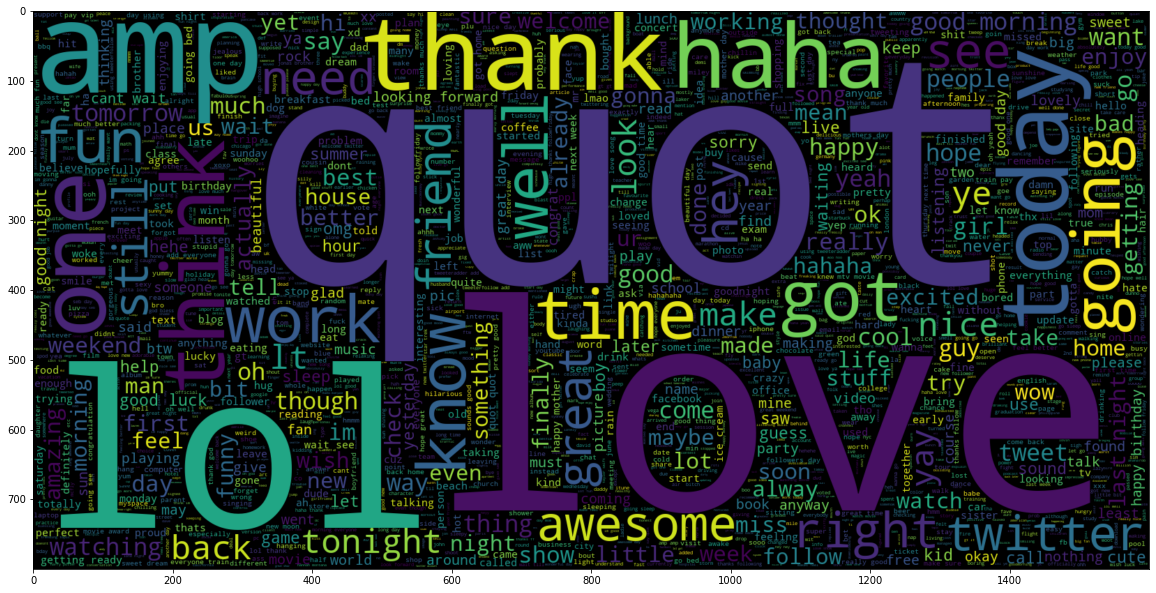

In [29]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 'POSITIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

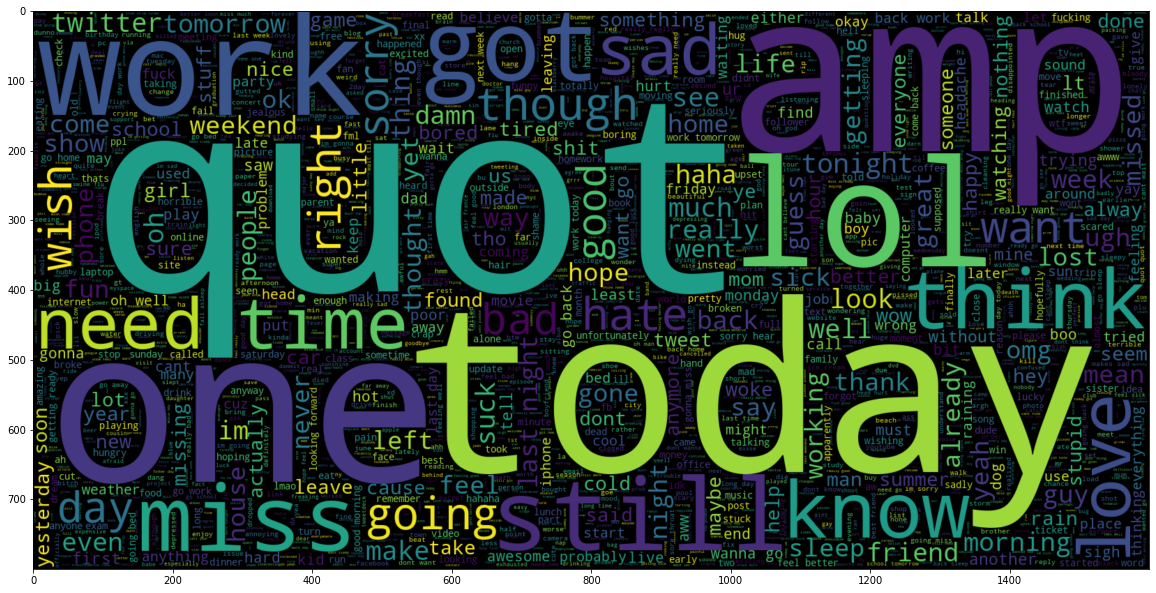

In [30]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 'NEGATIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [52]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

### Токенизация

In [53]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 186708


In [54]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=50)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=50)

In [105]:
words_dict = dict(tokenizer.word_counts)
sorted_words = dict(sorted(words_dict.items(), key=lambda item: item[1], reverse=True))

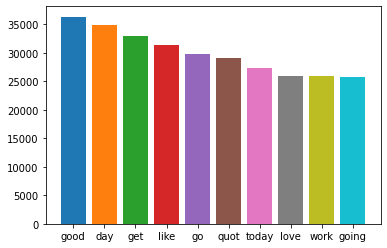

In [106]:
names = list(sorted_words.keys())
values = list(sorted_words.values())
for i in range(10):
  plt.bar(i,values[i],tick_label=names[i])
plt.xticks(range(10),names)
plt.show()

### Word2Vec 

In [56]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 24
W2V_MIN_COUNT = 10

In [57]:
documents = [_text.split() for _text in df_train.text] 

In [58]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [59]:
w2v_model.build_vocab(documents)

In [60]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 20240


In [62]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(97079746, 110848272)

In [63]:
w2v_model.most_similar("nice")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lovely', 0.5745750069618225),
 ('great', 0.5371126532554626),
 ('good', 0.4765537977218628),
 ('cool', 0.4248631000518799),
 ('beautiful', 0.41771408915519714),
 ('wonderful', 0.39889466762542725),
 ('perfect', 0.3875332474708557),
 ('fab', 0.37999236583709717),
 ('gorgeous', 0.37463805079460144),
 ('awesome', 0.35678771138191223)]

In [64]:
w2v_model.most_similar("pain")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hurts', 0.48711854219436646),
 ('hurting', 0.47865501046180725),
 ('swelling', 0.4655091166496277),
 ('aching', 0.4559847116470337),
 ('pains', 0.45226815342903137),
 ('migraine', 0.4415035843849182),
 ('swollen', 0.4372488856315613),
 ('hurt', 0.42637160420417786),
 ('headache', 0.4245782196521759),
 ('cramps', 0.41754063963890076)]

### Label Encoder 

In [70]:
labels = df_train.target.unique().tolist()
labels.append("NEUTRAL")
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [71]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (640000, 1)
y_test (160000, 1)


In [72]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (640000, 50)
y_train (640000, 1)

x_test (160000, 50)
y_test (160000, 1)


In [73]:
y_train[:10]

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1]])

### Embedding

In [75]:
embedding_matrix = np.zeros((186708, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(186708, 300)


In [78]:
embedding_layer = Embedding(186708, 300, weights=[embedding_matrix], input_length=50, trainable=False)

### Модель

In [79]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           56012400  
_________________________________________________________________
dropout (Dropout)            (None, 50, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 56,172,901
Trainable params: 160,501
Non-trainable params: 56,012,400
_________________________________________________________________


In [80]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [83]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [84]:

history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=7,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/7
563/563 [==============================] - 1214s 2s/step - loss: 0.5511 - accuracy: 0.7122 - val_loss: 0.4748 - val_accuracy: 0.7729
Epoch 2/7
563/563 [==============================] - 1212s 2s/step - loss: 0.4972 - accuracy: 0.7553 - val_loss: 0.4697 - val_accuracy: 0.7781
Epoch 3/7
563/563 [==============================] - 1202s 2s/step - loss: 0.4872 - accuracy: 0.7618 - val_loss: 0.4617 - val_accuracy: 0.7816
Epoch 4/7
563/563 [==============================] - 1196s 2s/step - loss: 0.4815 - accuracy: 0.7665 - val_loss: 0.4569 - val_accuracy: 0.7835
Epoch 5/7
563/563 [==============================] - 1200s 2s/step - loss: 0.4768 - accuracy: 0.7689 - val_loss: 0.4563 - val_accuracy: 0.7842
Epoch 6/7
563/563 [==============================] - 1215s 2s/step - loss: 0.4737 - accuracy: 0.7709 - val_loss: 0.4550 - val_accuracy: 0.7856
Epoch 7/7
563/563 [==============================] - 1207s 2s/step - loss: 0.4711 - accuracy: 0.7720 - val_loss: 0.4526 - val_accuracy: 0.7864

### Точность

In [86]:

score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

157/157 [==============================] - 69s 442ms/step - loss: 0.4527 - accuracy: 0.7859

ACCURACY: 0.7858750224113464
LOSS: 0.452665776014328


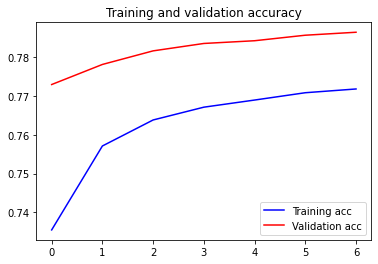

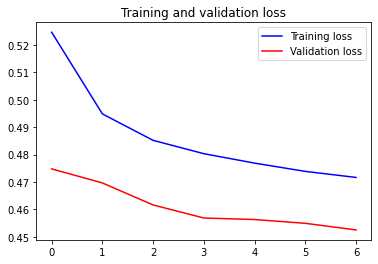

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [91]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

20/20 [==============================] - 65s 3s/step


In [92]:
accuracy_score(y_test_1d, y_pred_1d)

0.785875

In [93]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.77      0.78     79940
    POSITIVE       0.78      0.80      0.79     80060

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



In [89]:
thresholds = (0.4, 0.7)
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = "NEUTRAL"
        if score <= thresholds[0]:
            label = "NEGATIVE"
        elif score >= thresholds[1]:
            label = "POSITIVE"
        return label
    else:
        return "NEGATIVE" if score < 0.5 else "POSITIVE"

In [90]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

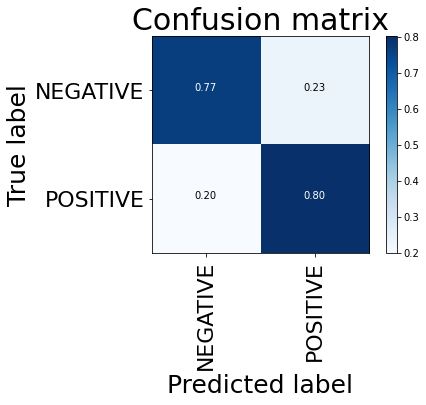

In [94]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [97]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=50)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),}  

In [98]:
predict("i eat")

{'label': 'NEUTRAL', 'score': 0.4549468159675598}

In [99]:
predict("water")

{'label': 'NEUTRAL', 'score': 0.42707017064094543}

In [100]:
predict("i love pain")

{'label': 'NEGATIVE', 'score': 0.3719154894351959}

In [102]:
predict('i love music')

{'label': 'POSITIVE', 'score': 0.9704698324203491}

In [103]:
predict('University is kinda cool')

{'label': 'POSITIVE', 'score': 0.9045641422271729}

In [101]:
model.save("model.h5")
w2v_model.save("model.w2v")